In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchvision matplotlib tensorboard

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import copy

In [ ]:
# Define data transformations
data_dir = '/content/drive/MyDrive/Characters/platecharacters'
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    if model_name == "alexnet":
        model_ft = models.alexnet(pretrained=use_pretrained)
    elif model_name == "vgg16":
        model_ft = models.vgg16(pretrained=use_pretrained)
        # Modify the final layer
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)

    return model_ft

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "alexnet"
num_classes = len(class_names)
feature_extract = True
model_ft = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Set parameters for feature extraction
set_parameter_requires_grad(model_ft, feature_extract)

# Move the model to the device
model_ft = model_ft.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 180MB/s]


In [ ]:
# K-Fold Cross-Validation with Logging
def k_fold_cross_validation(model_name, num_classes, feature_extract, k=5, num_epochs=20):
    kfold = KFold(n_splits=k, shuffle=True)

    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []
    fold_history = [] # Initialize fold_history as a list of dictionaries
    fold = 0

    for train_idx, valid_idx in kfold.split(image_datasets['train']):
        print(f'Fold {fold}')

        fold_data = {'train_loss_history': [], 'val_loss_history': [],
                     'train_acc_history': [], 'val_acc_history': []} # Create a dictionary to store fold data


        # Creating dataloaders for this fold
        train_subsampler = SubsetRandomSampler(train_idx)
        valid_subsampler = SubsetRandomSampler(valid_idx)

        dataloaders = {
            'train': DataLoader(image_datasets['train'], batch_size=16, sampler=train_subsampler, num_workers=4),
            'valid': DataLoader(image_datasets['train'], batch_size=16, sampler=valid_subsampler, num_workers=4)
        }

        model_ft = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
        model_ft = model_ft.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer_ft = optim.SGD(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.001, momentum=0.9)

        best_model_wts = copy.deepcopy(model_ft.state_dict())
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'valid']:
                if phase == 'train':
                    model_ft.train()
                else:
                    model_ft.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer_ft.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model_ft(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer_ft.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(dataloaders[phase].sampler)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].sampler)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'valid' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model_ft.state_dict())

                # Store history for the current fold
                if phase == 'train':
                    fold_data['train_acc_history'].append(epoch_acc)
                    fold_data['train_loss_history'].append(epoch_loss)
                else:
                    fold_data['val_acc_history'].append(epoch_acc)
                    fold_data['val_loss_history'].append(epoch_loss)


        model_ft.load_state_dict(best_model_wts)
        fold_history.append(fold_data)  # Append the current fold's data to fold_history
        fold += 1

    return model_ft, fold_history
# Perform k-fold cross-validation
model_ft,fold_history = k_fold_cross_validation(model_name, num_classes, feature_extract, k=5, num_epochs=20)

# Save the final model to Google Drive
model_save_path = '/content/drive/MyDrive/AlexNetCurve_OCR_kfold.pth'
torch.save(model_ft.state_dict(), model_save_path)

Fold 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0/19
----------
train Loss: 2.3069 Acc: 0.4324
valid Loss: 1.0827 Acc: 0.6673
Epoch 1/19
----------
train Loss: 0.7444 Acc: 0.7689
valid Loss: 0.5007 Acc: 0.8261
Epoch 2/19
----------
train Loss: 0.4993 Acc: 0.8346
valid Loss: 0.4656 Acc: 0.8639
Epoch 3/19
----------
train Loss: 0.4006 Acc: 0.8601
valid Loss: 0.3044 Acc: 0.8979
Epoch 4/19
----------
train Loss: 0.3957 Acc: 0.8729
valid Loss: 0.3167 Acc: 0.8733
Epoch 5/19
----------
train Loss: 0.3529 Acc: 0.8847
valid Loss: 0.2609 Acc: 0.9282
Epoch 6/19
----------
train Loss: 0.3012 Acc: 0.8974
valid Loss: 0.2724 Acc: 0.9187
Epoch 7/19
----------
train Loss: 0.2600 Acc: 0.9078
valid Loss: 0.2880 Acc: 0.9093
Epoch 8/19
----------
train Loss: 0.2823 Acc: 0.9060
valid Loss: 0.1783 Acc: 0.9414
Epoch 9/19
----------
train Loss: 0.2424 Acc: 0.9192
valid Loss: 0.1949 Acc: 0.9338
Epoch 10/19
----------
train Loss: 0.2125 Acc: 0.9239
valid Loss: 0.1864 Acc: 0.9263
Epoch 11/19
----------
train Loss: 0.2238 Acc: 0.9267
valid Loss: 0.2025 Ac

In [ ]:
# Specify the file path where you want to save the fold_history data
save_path = '/content/drive/MyDrive/fold_history_alexnet.pth'
torch.save(fold_history, save_path)

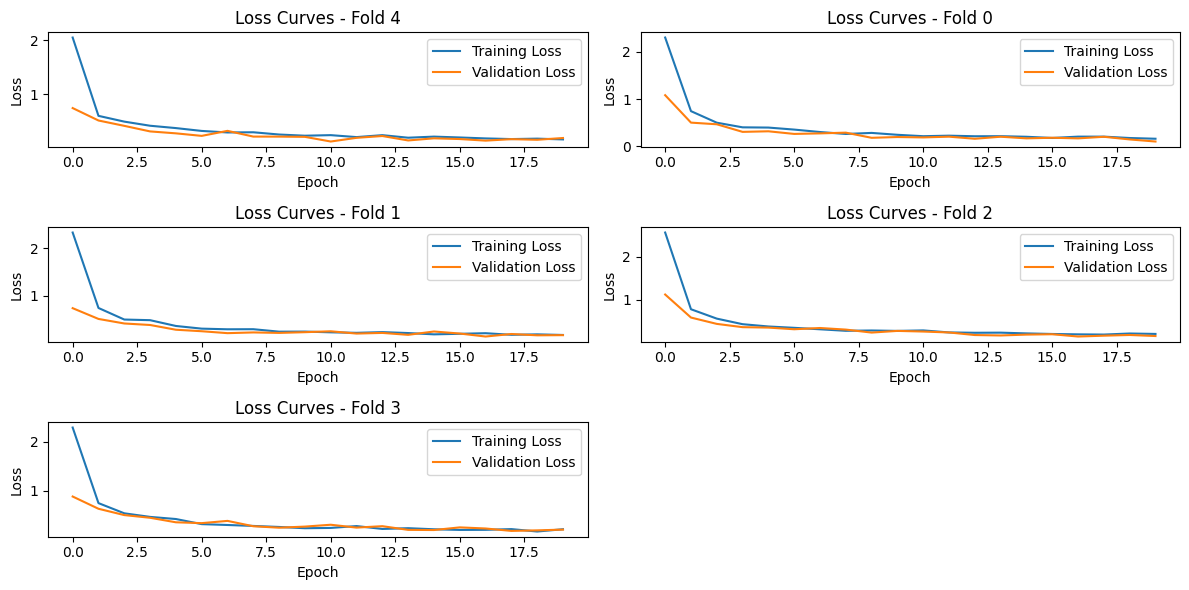

In [ ]:
import matplotlib.pyplot as plt

# Plotting the curves for fold 4 only
fold_index = 4  # Specify the fold index you want to plot

plt.figure(figsize=(12, 6))

# Plot for fold 4
plt.subplot(3, 2, 1)
plt.plot(fold_history[fold_index]['train_loss_history'], label='Training Loss')
plt.plot(fold_history[fold_index]['val_loss_history'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Loss Curves - Fold {fold_index}')

# Plot for fold 0
plt.subplot(3, 2, 2)
plt.plot(fold_history[0]['train_loss_history'], label='Training Loss')
plt.plot(fold_history[0]['val_loss_history'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Loss Curves - Fold {0}')

# Plot for fold 1
plt.subplot(3, 2, 3)
plt.plot(fold_history[1]['train_loss_history'], label='Training Loss')
plt.plot(fold_history[1]['val_loss_history'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Loss Curves - Fold {1}')

# Plot for fold 2
plt.subplot(3, 2, 4)
plt.plot(fold_history[2]['train_loss_history'], label='Training Loss')
plt.plot(fold_history[2]['val_loss_history'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Loss Curves - Fold {2}')

# Plot for fold 3
plt.subplot(3, 2, 5)
plt.plot(fold_history[3]['train_loss_history'], label='Training Loss')
plt.plot(fold_history[3]['val_loss_history'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Loss Curves - Fold {3}')

plt.tight_layout()  # Adjust subplots to fit in figure area.
plt.show()


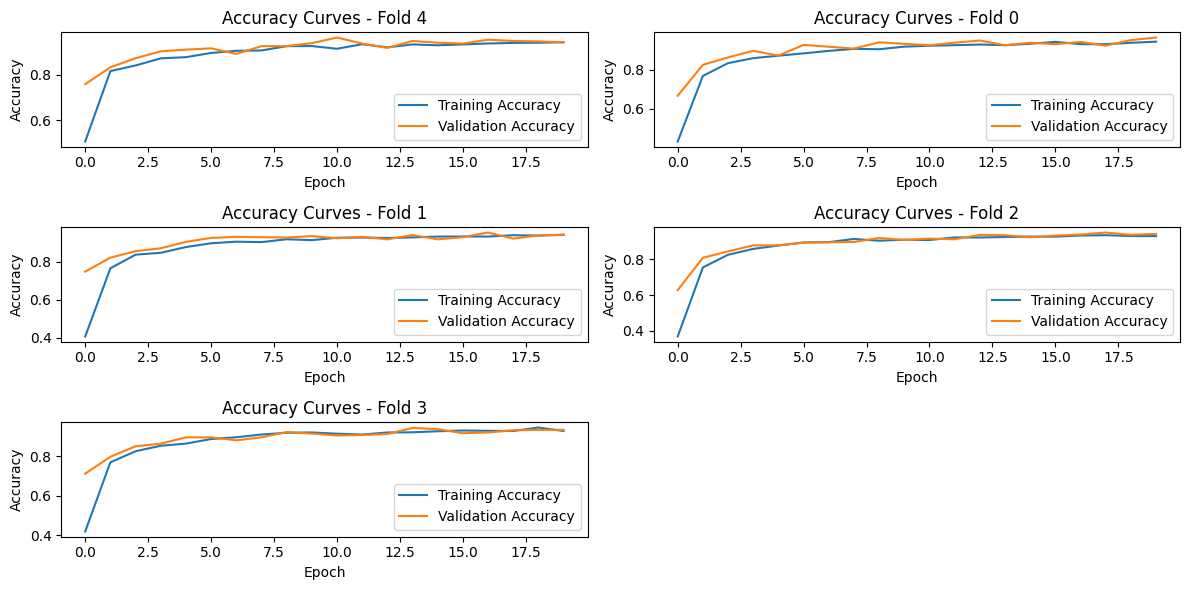

In [ ]:
# Plotting the curves for fold 4 only
fold_index = 4  # Specify the fold index you want to plot

plt.figure(figsize=(12, 6))
plt.subplot(3, 2, 1)
# Convert the list to a NumPy array for plotting, moving tensors to CPU first
plt.plot(np.array([t.cpu().item() for t in fold_history[fold_index]['train_acc_history']]), label='Training Accuracy')
plt.plot(np.array([t.cpu().item() for t in fold_history[fold_index]['val_acc_history']]), label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title(f'Accuracy Curves - Fold {fold_index}')

plt.subplot(3, 2, 2)
# Convert the list to a NumPy array for plotting, moving tensors to CPU first
plt.plot(np.array([t.cpu().item() for t in fold_history[0]['train_acc_history']]), label='Training Accuracy')
plt.plot(np.array([t.cpu().item() for t in fold_history[0]['val_acc_history']]), label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title(f'Accuracy Curves - Fold {0}')

plt.subplot(3, 2, 3)
# Convert the list to a NumPy array for plotting, moving tensors to CPU first
plt.plot(np.array([t.cpu().item() for t in fold_history[1]['train_acc_history']]), label='Training Accuracy')
plt.plot(np.array([t.cpu().item() for t in fold_history[1]['val_acc_history']]), label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title(f'Accuracy Curves - Fold {1}')

plt.subplot(3, 2, 4)
# Convert the list to a NumPy array for plotting, moving tensors to CPU first
plt.plot(np.array([t.cpu().item() for t in fold_history[2]['train_acc_history']]), label='Training Accuracy')
plt.plot(np.array([t.cpu().item() for t in fold_history[2]['val_acc_history']]), label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title(f'Accuracy Curves - Fold {2}')


plt.subplot(3, 2, 5)
# Convert the list to a NumPy array for plotting, moving tensors to CPU first
plt.plot(np.array([t.cpu().item() for t in fold_history[3]['train_acc_history']]), label='Training Accuracy')
plt.plot(np.array([t.cpu().item() for t in fold_history[3]['val_acc_history']]), label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title(f'Accuracy Curves - Fold {3}')

plt.tight_layout()
plt.show()

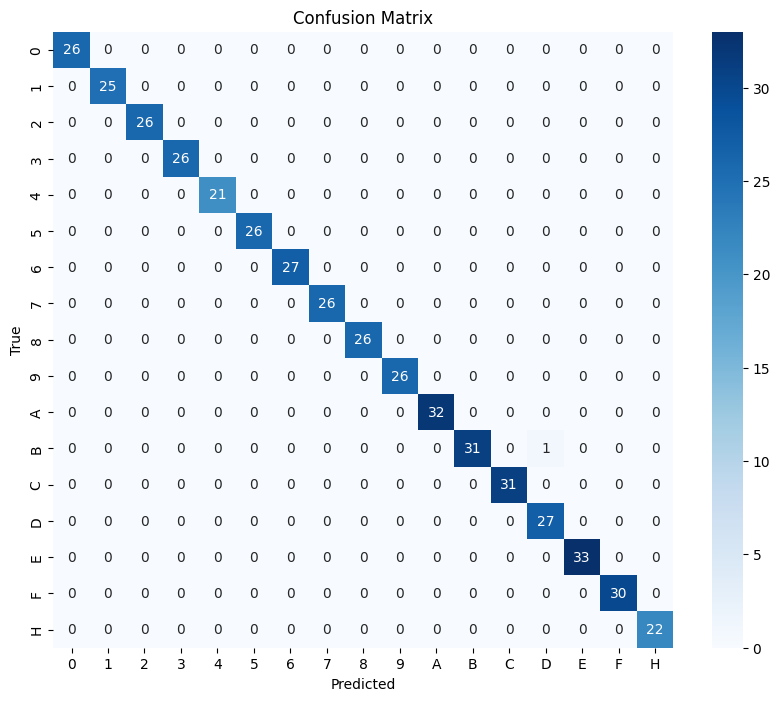

Accuracy: 0.9978
Precision: 0.9979
Recall: 0.9978


In [ ]:
# Test the model on the test dataset and create confusion matrix
test_loader = DataLoader(image_datasets['valid'], batch_size=16, shuffle=False, num_workers=4)
model_ft.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


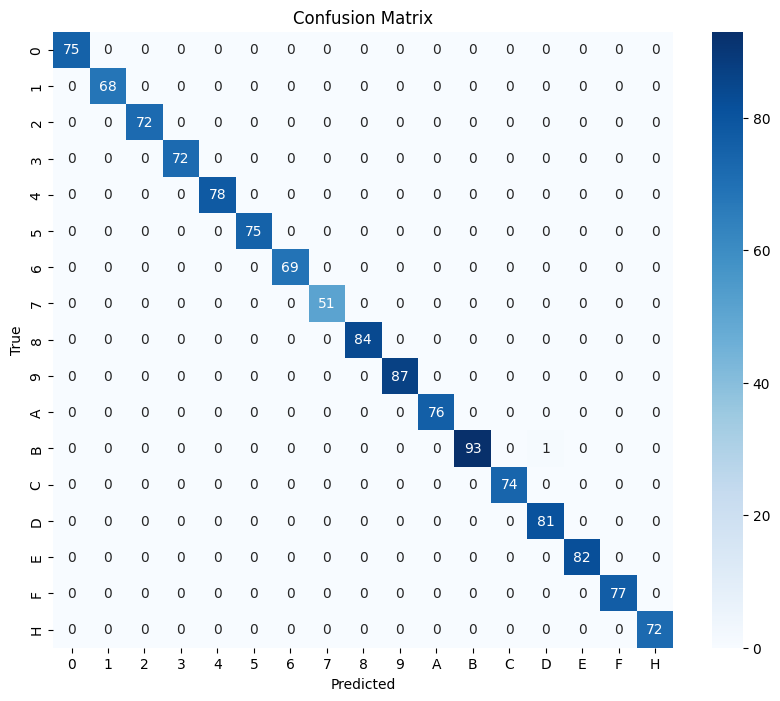

Accuracy: 0.9992
Precision: 0.9992
Recall: 0.9992


In [ ]:
# Test the model on the test dataset and create confusion matrix
test_loader = DataLoader(image_datasets['test'], batch_size=16, shuffle=False, num_workers=4)
model_ft.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

